# Contents
- [Dependencies](#Dependencies)
* [utils](#utils)
* [Data](#Data)
    + [Loading](#Loading)
    + [Massaging](#Massaging)
    + [Some insights about the number of timesteps in the different tasks](#Some-insights-about-the-number-of-timesteps-in-the-different-tasks)
* [Training](#Training)
    + [Cross-Validation (CV)](#Cross-Validation-(CV))
    + [Majority Voting](#Majority-Voting)
    + [Epoch](#Epoch)
    + [Step](#Step)
    + [Hyperparameters](#Hyperparameters)
      - [Random Search](#Random-Search)
* [Visualization](#Visualization)
    + [Metrics](#Metrics)
    + [Interpretation](#Interpretation)
    
# Dependencies

- PyTorch
- Sci-kit learn
- NumPy (should be included in PyTorch)
- Seaborn (very optional, only used to set the style of matplotlib)

In [3]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})#for prettier plots
#math tools
import numpy as np
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("using",device,"device")
#io
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle
#utils
from time import time
import warnings
#custom
from modules.utils import *
from modules.load_data import *
from modules.training import *
#models
from modules.model import Model
from modules.encoder import Encoder
from modules.tcn import *
from modules.CNN1d import CNN1d
from modules.HierarchicalCNN1d import HierarchicalCNN1d
from modules.HierarchicalStrokeCNN1d import HierarchicalStrokeCNN1d
from modules.HierarchicalStrokeCRNN import HierarchicalStrokeCRNN
from modules.HierarchicalRNN import HierarchicalRNN
from modules.CNNAutoencoder import CNNAutoencoder

using cuda device


# Utils
`utils.py` contains misc. utilitaries such as measures and task dictionaries, confusion matrix.

some extra utils in addition to `utils.py` due to the great number of parameters :
- plot plots either the loss or the accuracy of the model depending on `plot_i` (see `plot2index`)
- return_results formats the hyperparameters, the evaluation metrics and the index of the wrongly classified subjects to a nice string, separated by `;`
- print_results prints the above string for the epoch which provided the best accuracy in average among all 10 folds.

In [4]:

def plot(plot_i,train,valid,test,average=True):
    """plots either 
            loss if plot_i == 0
            accuracy if plot_i == 1
            (see plot2index)
    average should a priori be true only after a cross-validation
    if not run_CV you should probably set average to false"""
    if average:
        print(model_name.replace(",","|"))
        title = "average {} over 10 folds over {} epochs".format(index2plot[plot_i],n_epochs)
    else :
        train,test=np.asarray(train),np.asarray(test)
        if valid is not None:
            valid=np.asarray(valid)
        title=model_name
    plt.title(title)
    plt.plot(train[:,plot_i],label="training")
    if valid is not None:
        plt.plot(valid[:,plot_i],label="validation")
    plt.plot(test[:,plot_i],label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()
    if plot_i!=0:
        plt.ylim(0,1)

def return_results(train_metrics,valid_metrics,test_metrics,stopped_at,flat_falses):
    """formats the hyperparameters and the evaluation metrics to a nice string"""
    train_metrics,test_metrics=np.asarray(train_metrics),np.asarray(test_metrics)
    str_valid_metrics="NA"
    results="{} ; {} ; {}  ; {} ; {} ; {} ; {} ; {} ; {}; {}  ; {} ; {:.2f} (± {:.2f}); {} ; {} ; {} ; {} ; {} ; {} ; {} ; NA ; {} ; TRUE ; FALSE  ; {:.2f} (± {:.2f}) ; {} ".format(
    task_name,model_type,learning_rate, hidden_size,conv_kernel,pool_kernel,
        num_layers,dilation,bidirectional,dropout,clip,
    np.mean(stopped_at),np.std(stopped_at),max_len,augmentation,paper_air_split,letter_split,pad_subs,
        compute_movement_,early_stopping,downsampling_factor,
     np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]), str_valid_metrics)

    test_metrics=test_metrics.T
    for metric in test_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (± {:.2f}) ".format(mean,std)
    results+=" ; "
    results+=" ; ".join(map(str, flat_falses))
    return results
def print_results(fold_train_metrics,fold_test_metrics,fold_falses):
    """print the results using return_results for the best epoch in average among all 10 folds"""
    best_index=np.argmax(np.mean(fold_test_metrics,axis=0)[:,1])      
    stopped_at=[best_index+1]
    best_falses=[fold[best_index] for fold in fold_falses]
    flat_falses = sorted(flat_list(best_falses))
    results=return_results([fold[best_index] for fold in fold_train_metrics],
                 None, #[fold[best_index] for fold in fold_valid_metrics],
                  [fold[best_index] for fold in fold_test_metrics],
                  stopped_at,
                   flat_falses)
    print(results)
    return results

## Data
### Loading
is done in `load_data.py`. The load_data function yields subjects data, label (1 for PD 0 for control) and age. Note that it discards the subjects who didn't perform the spiral, i.e. Subjects 46 (control), 60 (PD) and 66 (control), counting from zero. Moreover, it trims the data for the few subjects who begin their exam in-air and the one where there is a measure error at the end, see [Data Exploration](#Data-Exploration). The raw data is then turned into a list in `Main`. It will be saved using pickle in `join("data","raw_data")` (i.e. `data/raw_data` in UNIX and Linux). In the future, raw data will be loaded directly from this path.

### Massaging
You can then select a task using `task_i` (cf. task2index). This is done in task_selection which is called in massage_data. Set `task_i` to None if you want to keep the whole eight tasks in the shape of (72 subjects, 8 task, x timesteps, 7 measures). Unfortunately, you have to select a task if you want to split it into strokes using `paper_air_split`. This is done in massage_data. After eventually splitting data into strokes, massage_data standardizes the data (giving it a mean of 0 and a std of 1) :
- t0 is removed from each timestamps so the time stamp measure represents the length of the exams
- Moreover, the timestamp is standardized globally, i.e. we compute the mean and std value of all subjects in a given task before centering and reducing the data
- unlike the timestamp, the other measures are scaled subject-wise, independently of all subjects, using [sklearn's scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)

After this, massage_data zero-pads (and trims if `trim`) the data to `max_len` if `max_len is not None`. This can also be done in epoch before feeding the subject to the model, see [Training](#Training).
The massaged data is then saved to a numpy array in `join("data","<custom name>")`. In the future, data will be loaded directly from this path.

### Some insights about the number of timesteps in the different tasks

These are stored as lists in `utils.py`

 The task sequence is in average **2286** &rarr; task duration is in average 11.4s  

 task | max duration | avg duration | avg duration std | avg duration per letters | max duration per tokens | max duration per stroke | max # of strokes | std of stroke duration | std of # of strokes
 --|--|--|--|--|--|--|--|--|--
 spiral | 16071 | 2873 | 2267.76 | 2758.75  | 16071| 16071|25|1715|3.57
 l | 4226|1639 | 724.14 | 333 | 1242|752|15|109 | 1.42
 le | 6615| 1966 | 999.61 | 198 | 1649|1104|15| 160 | 1.57
 les | 6827| 2301 | 1095.54 | 153| 1956|1476|21| 183 | 2.47
 lektorka | 7993| 2600 | 1333.76  | 163| ?|3568|29| 281 | 7.16
 porovnat | 5783| 2314 | 1033.69 |144| ?|2057|43| 198 | 8.72
 nepopadnout | 4423| 1473 | 650.65 | 133| ?|2267|35| 189 | 6.85
 tram | 7676| 3094 | 1158.81 | 146| ?|1231|67| 117 | 8.38

In [13]:

## Loading
#Cf `load_data.py`
task_i = 1#range(8):
task_name=index2task[task_i] if task_i is not None else str(task_i)
raw_data_path=join("data","raw_data")
#data_path=join("data","data_trim_per_task.npy".format(task_name))
data_path=join("data","stroke_split_{}.npy".format(task_name))
target_path=join("data","targets.npy")
compute_speed_accel_=False
compute_movement_=False
downsampling_factor=1
window_size=None#256
paper_air_split=True
letter_split=False
discard_non_letters=False
pad_subs=False
#used to trim and pad the data, Set to None if you don't want to
if letter_split:
    max_len=token_lengths
elif paper_air_split:
    max_len=stroke_lengths 
else:
    max_len=max_lengths
max_len=max_len[task_i] if task_i is not None else max_len
trim=False
if max_len is None and trim:
    warnings.warn("trim is not effective as max_len is None")
if discard_non_letters and pad_subs:
    warnings.warn("discard_non_letters and pad_subs are mutually exclusive, a priori")
if letter_split and not paper_air_split:
    warnings.warn("setting paper_air_split at True as letter_split is !")
    paper_air_split=True
if discard_non_letters and not paper_air_split:
    warnings.warn("setting paper_air_split at True as discard_non_letters is !")
    paper_air_split=True
if window_size is not None and paper_air_split:
    warnings.warn("you have to choose between subsequences of fixed length and strokes !")
if task_i is None and (compute_movement_ or compute_speed_accel_ or window_size is not None or paper_air_split):
    raise NotImplementedError("""compute_movement_ and compute_speed_accel_ 
                              are only implemented for single task learning !
                              Subsequences are not are only implemented for single task learning.""")  
elif discard_non_letters and letter_split:
    raise ValueError("discard_non_letters and letter_split are mutually exclusive ! Set one to False")
elif not exists(data_path):
    if not exists(raw_data_path):
        print("\nloading and massaging data, this might take a few seconds...")
        data_gen=load_data()
        data,targets=[],[]
        for subject,label,_ in data_gen:
            data.append(subject)
            targets.append(label)
        with open(raw_data_path, 'wb') as fp:
            pickle.dump(data, fp)
        targets=np.asarray(targets)
        np.save(target_path,targets)
    else:
        print("loading raw data from",raw_data_path)
        with open(raw_data_path, 'rb') as fp:
            data=pickle.load(fp)
        print("loading targets from",target_path)
        targets=np.load(target_path)
    print("(75-3 subjects, 8 tasks, X timesteps, 7 measures) :")
    print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))
    if compute_movement_ and compute_speed_accel_:
        warnings.warn("Only speed and accel will be computed ! \nSet compute_speed_accel_ to False if you want to compute movement")
    data= massage_data(data,task_i, compute_speed_accel_,compute_movement_,
                                downsampling_factor, window_size,paper_air_split,max_len=max_len,
                                letter_split=letter_split,discard_non_letters=discard_non_letters,pad_subs=pad_subs,trim=trim)
    np.save(data_path,data)
else:
    print("loading data from",data_path)
    data=np.load(data_path)
    print("loading targets from",target_path)
    targets=np.load(target_path)
    print(data.shape,targets.shape)

if window_size is not None:
    seq_len=window_size
elif max_len is not None and trim:
    seq_len=max_len
elif paper_air_split or task_i is None:
    seq_len=max([len(sub) for task in data for sub in task])
else:
    seq_len=max([len(task) for task in data])
n_seq=len(data[0]) if paper_air_split else 1
print("max length, # of sub sequences (may vary):",seq_len,n_seq)


loading data from data/stroke_split_l.npy
loading targets from data/targets.npy
(72,) (72,)
max length, # of sub sequences (may vary): 752 9


## Adapt data to IamonDo model

In [14]:
keep_measures=np.asarray([
    measure2index["x-coordinate"],measure2index["y-coordinate"],measure2index["timestamp"],measure2index["pressure"]])
max_len=1050
seq_len=max_len
downsampling_factor=2#downsample *2 because IamonDO is 75 Hz and not 150

for i, subject in enumerate(data):
    iamondo_subject=[]
    for j, stroke in enumerate(subject):
        if stroke[0,measure2index["button_status"]]==on_paper_value:#keep only the on-paper strokes
            if downsampling_factor!=1:
                stroke = downsample(stroke,downsampling_factor)
            #keep only the measures that exists in iamondo and in THE SAME ORDER
            iamondo_subject.append(stroke[:,keep_measures])
    data[i]=iamondo_subject

## Training
The Cross-Validation (CV) function and the Majority Voting function are implemented in Main because of the great number of parameters. The training step and epoch function are in `training.py`

### Cross-Validation (CV)

You can use the CV function even if you want to train on only one fold (i.e. one dataset split) by setting `run_CV` to `False`. In this case, you can use `start_at_fold` to skip the the first `start_at_fold` folds (thus it should be smaller than `n_splits`, but that's up to the user).

You can choose the number of splits (e.g. 10 fold cross validation) using n_splits and the # of epochs using n_epochs. We only used 10 CV in all our experiments to keep consistent results with Drotar et al. and Moetesum et al. The actual split is done using [sklearn's StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), with a random_state set at `1` so that the split is always the same. The random seed is always set at `1` in NumPy and PyTorch before doing any random operation. Note that the CV is stratified, meaning that there's the same # of PDs and HCs in the data sets.

If you want to use 2 different models for on-paper and in-air strokes, you should dive into the CV code and initialize `in_air` the same way as `model`.

The model is trained using the [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) with the learning rate defined in [Hyperparameters](#Hyperparameters), the other hyperparameters are kept to the PyTorch's default setting (which respects the advices of the original paper).

At the end of the Cross-validation, if `run_CV`, the program will dump the `fold_train_metrics` and the `fold_test_metrics` using Pickle in `join("experiments",model_name)+<train or test>`, with `model_name` being the concatenation of `model_type` and other hyperparameters. In the same way, it will save the models' predictions in `join("predictions",model_name)+<train or test>`. It will also save the results (as defined in [utils](#utils)) to the gitignored-file : `results.csv`.

### Majority Voting

The majority voting function allows you to combine the predictions of the different model, either directly stored in `model_test_predictions` or loaded from the `predictions` folder.

You can control whether to perform actual majority voting or to fuse the models' predictions' probability using `round_before_voting`. The rest of the function is very similar to CV.

### Epoch
`batch_size` should be `1`, you're welcome to implement batch learning but it's not suited for a small dataset like PaHaW.

Depending on `paper_air_split` and `hierarchical` (see [Hyperparameters](#Hyperparameters)), the epoch function will either :
- go through all the data which index is in `random_index` (provided by the CV function), or
- if `paper_air_split and not hierarchical`, the model will shuffle the strokes of every subjects, go through every of them, saving the model predictions in the `predictions` *dictionary*, then fuse the predictions of the model for each subject (i.e. task). If you want to use majority voting rather than prediction's provability averaging, you will have to dive in the code under the line : `predictions=[np.mean(sub) for sub in list(predictions.values())]`

Regardless of `paper_air_split` and `hierarchical` the epoch function will zero-pad (but not trim) the data to `max_len` if not `None`.

### Step
The step functions either performs a training step using the above model, optimizer and loss function (see [Hyperparameters](#Hyperparameters)) or a simple forward pass using the model if `validation`. In the former case, the step function may clip the gradients norm of the RNN (part of the) model before back-propagating, if you use a RNN and if `clip is not None`.

In [35]:
def CV(run_CV=True,n_splits=10,n_epochs=100,data=data,start_at_fold=0,max_len=None):
    """
    run_CV : if False, breaks after one fold, else runs CV
    n_splits : # of splits for the cross validation, e.g. 10 fold cross validation
    n_epochs: max n° of epochs the model will be trained to 
    start_at_fold : skip folds if > 0 and not run_CV
    max_len : zero-pads but does not trim the data to max_len if not None
    """
    verbose=False
    fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
    fold_train_predictions,fold_test_predictions=[],[]
    start = time()
    np.random.seed(1)
    skf = StratifiedKFold(n_splits=n_splits, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)

    for fold,(train_index,test_index) in enumerate(cv_generator): 

        if fold in np.arange(start_at_fold) and not run_CV:
            print("SKIPPING FOLD n°",fold)
            continue
        train_metrics,test_metrics,falses=[],[],[]
        train_predictions,test_predictions=[],[]

        torch.manual_seed(1)#random seed for weights init
        hierarchical=False#except if model_type=="hcnn1d"
        in_air=None#unless redefined below
        if model_type=="tcn":
            model= TemporalConvNet(input_size,hidden_size,kernel_size,dropout,output_size=1,dilation_factor=dilation_factor)
        elif model_type=="lstm":
            model=Model(input_size, hidden_size[0],num_layers, bias,batch_first,
                         dropout,bidirectional, batch_size,output_size, is_lstm=True)
            model.init_forget_bias()
        elif model_type=="gru":
            model=Model(input_size, hidden_size[0],num_layers, bias,batch_first,
                         dropout,bidirectional, batch_size,output_size, is_lstm=False)
        elif model_type=="hrnn":
            hierarchical=True
            model=HierarchicalRNN(input_size, hidden_size[0], bias,
                         dropout, batch_size,output_size, is_lstm=True)
        elif model_type=="pretrained":
            load_model = join("weights", #parent directory
                    pre_trained_name,
                    '{}_checkpoint.tar'.format(49)#epoch to load at
                   )
            checkpoint = torch.load(load_model)
            model_sd = checkpoint['model']
            model=CNN1d(input_size,conv_seq_len,hidden_size,conv_kernel,
                              pool_kernel ,padding,stride,dilation, dropout,output_size)
            model.load_state_dict(model_sd)
            for m in model.model[:16]:
                if isinstance(m,torch.nn.Conv1d):#freeze conv weights
                    for p in m.parameters():
                        p.requires_grad=False
        elif model_type=="cnn1d":
            model=CNN1d(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout,output_size)
            #in_air=CNN1d(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout,output_size)
        elif model_type=="hcnn1d":
            hierarchical=True
            model=HierarchicalCNN1d(input_size,conv_seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size)
        elif model_type=="hscnn1d":
            hierarchical=True
            model=HierarchicalStrokeCNN1d(input_size,conv_seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size)  
        elif model_type=="hsclstm":
            hierarchical=True
            model=HierarchicalStrokeCRNN(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,
                                         padding,stride,dilation, dropout,bidirectional,output_size, is_lstm=True)
        elif model_type=="hscgru":
            hierarchical=True
            model=HierarchicalStrokeCRNN(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,
                                         padding,stride,dilation, dropout,bidirectional,output_size, is_lstm=False)             
        else:
            raise ValueError("got {} as model_type but expected one of {}".format(model_type,model_types))
        model=model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        if in_air is not None:
            in_air=in_air.to(device)
            in_air_optimizer = torch.optim.Adam(in_air.parameters(), lr=learning_rate)
        else:
            in_air_optimizer = None
        if fold==0:        
            print("(total n° of parameters, n° of trainable parameters) :")
            print(count_params(model))   
            print("architecture :")
            print(model)
        for i in range(n_epochs):  
            np.random.shuffle(train_index)#shuffle training to facilitate SGD        
            #training
            model.train()
            if in_air is not None:
                in_air.train()
            condition_targets,predictions,loss=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, train_index,in_air,in_air_optimizer,device=device,
                clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,
                paper_air_split=paper_air_split,hierarchical=hierarchical,max_len=max_len)
            train_predictions.append(predictions)
            #compute metrics
            tn, fp, fn, tp, _ = confusion_matrix(y_true=condition_targets,y_pred=np.around(predictions))
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])

            #test
            model.eval()            
            if in_air is not None:
                in_air.eval()
            condition_targets,predictions,loss=epoch(
                data, targets, model, optimizer, loss_fn, batch_size, test_index,in_air,in_air_optimizer,device=device,
                validation=True,window_size=window_size,task_i=task_i,augmentation=None,
                paper_air_split=paper_air_split,hierarchical=hierarchical,max_len=max_len) 
            test_predictions.append(predictions)
            #compute metrics
            tn, fp, fn, tp, false_i = confusion_matrix(y_true=condition_targets,y_pred=np.around(predictions))
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            false=[test_index[i] for i in false_i]
            test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)  

        fold_train_metrics.append(train_metrics)
        fold_train_predictions.append(train_predictions)
        fold_test_metrics.append(test_metrics)
        fold_test_predictions.append(test_predictions)
        fold_falses.append(falses)
        if not run_CV:
            print("Done. Spent",timeSince(start))
            return train_metrics,test_metrics,model,in_air,train_predictions,test_predictions

    if run_CV:   
        # Save metrics
        filename=join("experiments",model_name)
        for metrics,metric_type in list(zip([fold_train_metrics,
        fold_test_metrics],["train","test"])):
            with open(filename+metric_type, 'wb') as fp:
                pickle.dump(metrics, fp)
        filename=join("predictions",model_name)
        for metrics,metric_type in list(zip([fold_train_predictions,fold_test_predictions],["train","test"])):
            with open(filename+metric_type, 'wb') as fp:
                pickle.dump(metrics, fp)   
        results=print_results(fold_train_metrics,fold_test_metrics,fold_falses) 
        with open("results.csv","a") as file:
            file.writelines(results+"\n")
        print("Done. Spent",timeSince(start))
        return fold_train_metrics,fold_test_metrics,model,in_air,fold_train_predictions,fold_test_predictions

def MajorityVoting(model_train_predictions,model_test_predictions,data=data,n_epochs=100,round_before_voting=True):
    """round_before_voting=True -> actual Majority Voting
    round_before_voting=False -> Fuse model prodections' probability"""
    voted_train_predictions=ReshapeAndVote(model_train_predictions,round_before_voting)
    voted_test_predictions=ReshapeAndVote(model_test_predictions,round_before_voting)
    np.random.seed(1)
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)
    fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
    for fold,(train_index,test_index) in enumerate(cv_generator): 
        #print(test_index)
        train_metrics,test_metrics,falses=[],[],[]
        for i in range(n_epochs):  
            np.random.shuffle(train_index)#shuffle training to match CV 
            #TRAIN
            tn, fp, fn, tp, _ = confusion_matrix(y_true=targets[train_index],y_pred=voted_train_predictions[fold][i])
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            train_metrics.append([0,accuracy,sensitivity,specificity,ppv,npv])
            #TEST
            #compute metrics
            tn, fp, fn, tp, false_i = confusion_matrix(y_true=targets[test_index],y_pred=voted_test_predictions[fold][i])
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            false=[test_index[i] for i in false_i]
            test_metrics.append([0,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)  
        fold_train_metrics.append(train_metrics)
        fold_test_metrics.append(test_metrics)
        fold_falses.append(falses)
    results=print_results(fold_train_metrics,fold_test_metrics,fold_falses) 
    with open("results.csv","a") as file:
        file.writelines(results+"\n")
    filename=join("experiments","voting"+model_name)
    for metrics,metric_type in list(zip([fold_train_metrics,
    fold_test_metrics],["train","test"])):
        with open(filename+metric_type, 'wb') as fp:
            pickle.dump(metrics, fp)
    return fold_train_metrics,fold_test_metrics



## Hyperparameters

The loss function should always be [Binary Cross Entropy](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss) as all our models have a Sigmoid activation and are trained to a binary classification task.

You can choose which model to use with `model_type` by selecting one of :
- lstm
- gru
- hrnn
- tcn (from [Locus Lab](https://github.com/locuslab/TCN))
- pretrained (see below)
- cnn1d
- hcnn1d
- hscnn1d
- hsclstm
- hscgru


They all are defined in `modules/`. If you select `pretrained` you should also define `pre_trained_name` which should correspond to the name of a pre-trained model stored in `weights/`.

Note that the hyperparameters are not always relevant for the chosen `model_type`. In this case they won't matter. Give them a random value.

`input_size` refers to the number of measures/features that you are using to train the model (default : 7).

The CorrectHyperparameters function is defined in `utils.py` and makes the CNNs hyperparameters consistent with the input shape, e.g. the pooling kernel should divide the input length.

All the other hyperparameters are pretty straightforward so I'll let you refer to the PyTorch documentation :
- [LSTM](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [GRU](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)
- [1D Convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d)
- [Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)

#### Random Search
You can perform a random search of the hyperparameters by setting `random_search` to True. You can play with the different ranges of the hyperparameters using the `ranges` dictionary.


In [ ]:
ranges={
    "num_layers":np.arange(1,5),
    "learning_rate": [1e-3,1e-4],
    "dropout": np.arange(0,0.6,0.1),
    "hidden_size": [2**i for i in range(2,8)],
    "dilation": [2**i for i in range(5)],
    "conv_kernel": [2**i for i in range(5)],
    "pool_kernel": [2**i for i in range(0,10)],
}

warnings.warn("setting n_seq at 1")
n_seq=1

random_search = False
run_CV=True
n_epochs=100
start_at_fold=6#skip folds if > 0 and not run_CV
early_stopping=False
if early_stopping:
    warnings.warn("early_stopping is deprecated, the model will not early stop.")
for experiment in range(10000):
    if random_search:
        print("random_search ranges",ranges)
        if not run_CV:
            warnings.warn("performing random_search but not CV")
        np.random.seed()
        num_layers=np.random.choice(ranges["num_layers"])
        learning_rate = np.random.choice(ranges['learning_rate'])
        dropout=np.random.choice(ranges['dropout'])
        hidden_size,conv_kernel,pool_kernel,dilation=[],[],[],[]
        for _ in range(num_layers):
            hidden_size.append(np.random.choice(ranges["hidden_size"]))
            conv_kernel.append(np.random.choice(ranges["conv_kernel"]))
            pool_kernel.append(np.random.choice(ranges["pool_kernel"]))
            dilation.append(np.random.choice(ranges["dilation"]))
        print(list(zip(ranges.keys(),
                       [num_layers,learning_rate,dropout,hidden_size,dilation,conv_kernel,pool_kernel])))
    else:   
        #e2h CNN
        learning_rate = 1e-3
        dropout=0.1
        #for RNNs, hidden_size[0] will be used. 
        hidden_size=[16,32]  
        conv_kernel= [16,4]
        pool_kernel=[80,141]
        dilation= [4,16]  #"redef as {}**i".format(dilation_factor)#meant for the conv layer
        #CNN-One
        #hidden_size,conv_kernel,pool_kernel,dilation,dropout=[16], [2] , "redef in for loop" , [16],0.2
        #CNN-Two
        #hidden_size,conv_kernel,pool_kernel,dilation,dropout=[4, 32] ,[16, 16] , [64, 128] ,[2, 2],0.3
        #CNN-Three
        #learning_rate,hidden_size,conv_kernel,pool_kernel,dilation,dropout= 0.0001, [128, 32, 128],[16, 4, 1],[8, 16, 1] , [16, 16, 1] ,0.3
        #pretrained
        learning_rate,hidden_size,conv_kernel,pool_kernel,dilation,dropout=0.001, [16,32, 64, 128,256], [128,64,32,16, 8] , [3,2,3,2,3] , [1,1,1,1,1] ,0.1


    model_types=["lstm","gru","hrnn","tcn","pretrained","cnn1d","hcnn1d","hscnn1d","hsclstm","hscgru"]
    model_type="pretrained"#model_types[-1]
    assert model_type in model_types
    #used for all models
    input_size=4
    augmentation=None
    num_layers=len(hidden_size)
    clip=None#clipping value to clip the gradients norm : set to None if you don't want to clip

    #for CNNs
    padding=[1 ,0,1,1,0]
    #padding=[0 for _ in range(num_layers)]#meant for the conv layer
    dilation_factor=1
    stride='redef as kernel_size'#stride=50#meant for the pool layer
    input_noise=0.0#for AE
    pre_trained_name="('cnn1d', 0.001, [16, 32, 64, 128, 256], 0.1, [128, 64, 32, 16, 8], [3, 2, 3, 2, 2], [1, 1, 1, 1, 1])"
    bidirectional=False# for RNNs

    #used for all models but shouldn't change a priori
    bias=True
    batch_first=False#we should unsqueeze(1) to add a batch dimension
    batch_size=1
    output_size=1#binary classif : 1 means PD, 0 means control
    loss_fn=torch.nn.BCELoss()#Binary cross entropy    
    print("input_size :",input_size)   
      
    if run_CV:
        #10 CV
        #fold_train_metrics,fold_test_metrics,models,model_metrics=CV(run_CV,n_epochs)
        model_train_predictions,model_test_predictions=[],[]
        model_train_metrics,model_test_metrics=[],[]
        task_iterator = task2index.items() if task_i is None else [(index2task[task_i],task_i)]
        for task_name,task_i in task_iterator:  
            #seq_len=max_lengths[task_i]
            #pool_kernel=[round((seq_len-240)/58), 16, 1] 
                
            if model_type in model_types[-6:]:#CNNs
                input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,padding,stride,dilation, dropout,output_size=CorrectHyperparameters(
                    input_size,seq_len,hidden_size
                                            ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size,n_seq) 
            model_name=str((model_type,task_name,augmentation,learning_rate,hidden_size,num_layers, bidirectional, dropout,
                               clip,window_size,conv_kernel,pool_kernel,dilation,downsampling_factor))
            print(model_name)
            if task_iterator==task2index.items():
                effective_data=data[:,task_i]
            else:
                effective_data=data
            fold_train_metrics,fold_test_metrics,model,in_air,fold_train_predictions,fold_test_predictions=CV(
                    run_CV,10,n_epochs,effective_data,max_len=max_len)
            model_train_predictions.append(fold_train_predictions)
            model_test_predictions.append(fold_test_predictions)
            model_train_metrics.append(fold_train_metrics)
            model_test_metrics.append(fold_test_metrics)
                 
        if task_iterator==task2index.items():
            warnings.warn("task_i is now set at {}".format(task_i))
    else:
        #single fold training
        model_name=str((model_type,task_name,learning_rate,hidden_size,num_layers, bidirectional, dropout,
                               clip,window_size,conv_kernel,pool_kernel,dilation,downsampling_factor))
        print(model_name)
        train_metrics,test_metrics,model,in_air,train_predictions,test_predictions=CV(run_CV,10,n_epochs,data,start_at_fold,max_len=max_len)
    if not random_search:
        break

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: setting n_seq at 1
  # This is added back by InteractiveShellApp.init_path()


input_size : 4
seq_len : 1050
layer 1
	after conv1 :925
	after pool1 :308
layer 2
	after conv2 :245
	after pool2 :122
layer 3
	after conv3 :93
	after pool3 :31
layer 4
	after conv4 :18
	after pool4 :9
layer 5
	after conv5 :2
	after pool5 :1
after flatting 256
('pretrained', 'l', None, 0.001, [16, 32, 64, 128, 256], 5, False, 0.1, None, None, [128, 64, 32, 16, 8], [3, 2, 3, 2, 2], [1, 1, 1, 1, 1], 2)
(total n° of parameters, n° of trainable parameters) :
(500961, 262913)
architecture :
CNN1d(
  (model): Sequential(
    (0): Conv1d(4, 16, kernel_size=(128,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1)
    (4): Conv1d(16, 32, kernel_size=(64,), stride=(1,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1)
    (8): Conv1d(32, 64, kernel_size=(32,), stride=(1,), padding=(1,))
    (9): ReLU()
    (10): MaxPool1d(

In [10]:
fold_train_metrics,fold_test_metrics=MajorityVoting(model_train_predictions,model_test_predictions,data[:,0])

tram ; _cnn1d ; 0.0001  ; [128, 32, 128] ; [16, 4, 1] ; [128, 10, 1] ; 3 ; [16, 16, 1] ; False; 0.3  ; None ; 68.00 (± 0.00); None ; None ; False ; False ; False ; False ; False ; NA ; 1 ; TRUE ; FALSE  ; 0.96 (± 0.02) ; NA ; 0.62 (± 0.13) ; 0.37 (± 0.25) ; 0.87 (± 0.14) ; 0.58 (± 0.35) ; 0.59 (± 0.10)  ; 0 ; 4 ; 5 ; 7 ; 8 ; 9 ; 12 ; 17 ; 18 ; 19 ; 20 ; 21 ; 27 ; 29 ; 30 ; 31 ; 35 ; 36 ; 37 ; 41 ; 42 ; 49 ; 54 ; 55 ; 58 ; 60 ; 63 ; 64


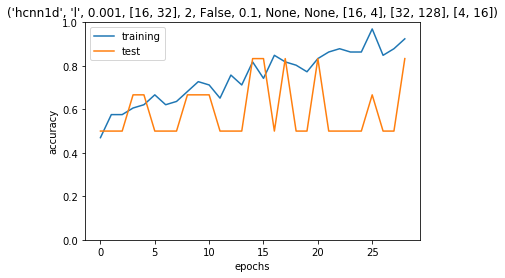

In [130]:
plot(1,train_metrics,None,test_metrics,False)

## Visualization

### Metrics

This allows you to visualize the results of your model using the plot function defined in `utils`.

You can either visualize the results currently stored in `fold_test_metrics` or load them from the `experiments` folder.

In [1]:
load_results=False

In [6]:
if load_results:
    patience=10
    n_epochs=100
    model_name="('cnn1d', 'spiral', 0.001, [4, 32], 2, False, 0.30000000000000004, None, None, [16, 16], [64, 128], [2, 2])"
    filename=join("experiments",model_name)
    early_stopping=False
    metrics=[]
    for metric_type in ["train","test"]:
        with open (filename+metric_type, 'rb') as fp:
            metrics.append(pickle.load(fp))

    fold_train_metrics, fold_test_metrics=metrics
    print("succesfullyl loaded metrics from",model_name)
else:
    warnings.warn("did nothing, load_results : {}".format(load_results))

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: did nothing, load_results:False
  from ipykernel import kernelapp as app


In [27]:
avg_train=np.mean(fold_train_metrics,axis=0)
#avg_valid=np.mean(fold_valid_metrics,axis=0)
avg_test=np.mean(fold_test_metrics,axis=0)
    

('cnn1d'| 'tram'| None| 0.001| [16]| 1| False| 0.2| None| None| [2]| [303]| [16])


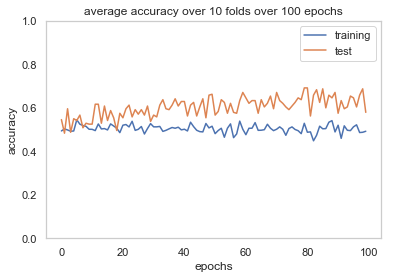

In [30]:
plot(1,avg_train,None,avg_test)

('cnn1d'| 'l'| None| 0.0001| [128| 32| 128]| 3| False| 0.3| None| None| [16| 4| 1]| [8| 16| 1]| [16| 16| 1]| 1)


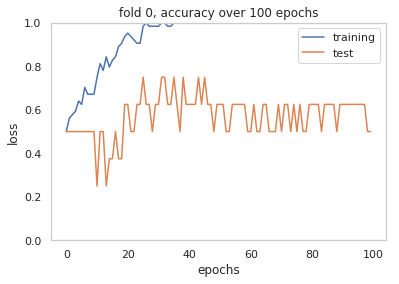

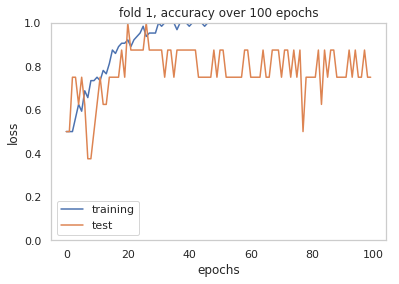

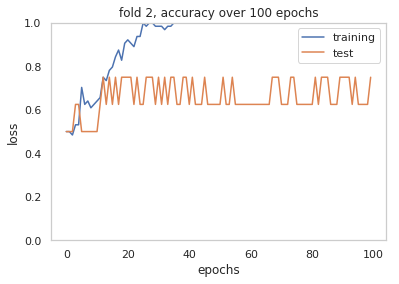

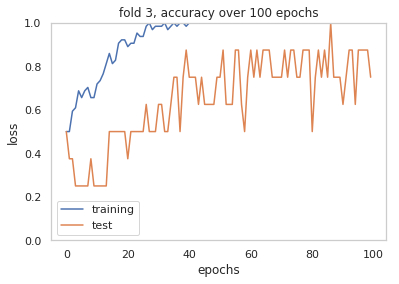

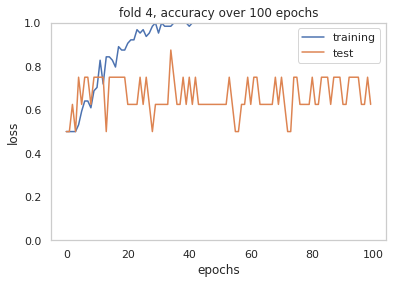

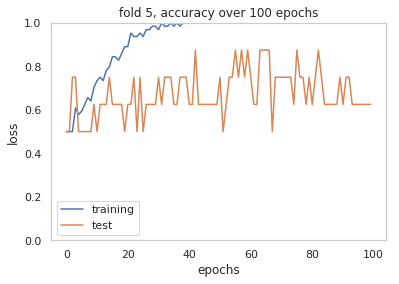

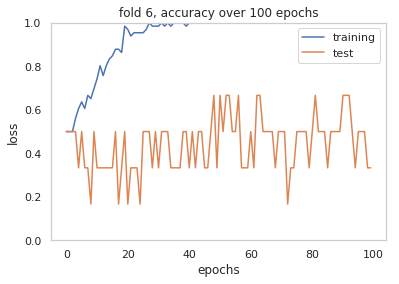

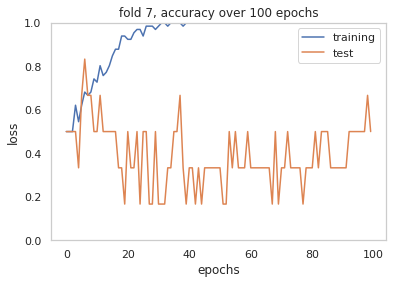

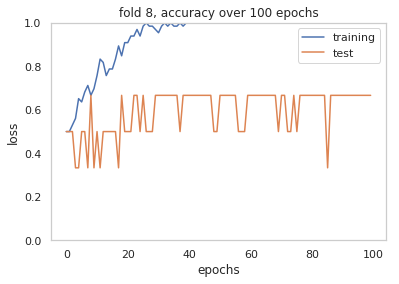

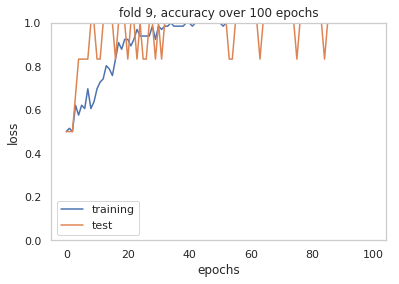

In [104]:
print(model_name.replace(",","|"))
for i in range(10):
    plt.figure()
    plt.title("fold {}, accuracy over {} epochs".format(i,len(fold_train_metrics[i])))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training")
    plt.plot(np.asarray(fold_test_metrics[i])[:,1],label="test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.ylim(0,1)
    plt.legend()

In [54]:
model_names=[]
for task_name,task_i in task2index.items():
    model_names.append("('cnn1d', '{}', None, 0.001, [16], 1, False, 0.2, None, None, [2], [{}], [16])".format(task_name,
                                                                                                              (stroke_lengths[task_i]-16)//4))
    

In [61]:
model_train_predictions,model_test_predictions=[],[]
model_train_metrics,model_test_metrics=[],[]
for m_name in model_names[:]:    
    filename=join("predictions",m_name)
    with open (filename+"train", 'rb') as fp:
        model_train_predictions.append(pickle.load(fp))
    with open (filename+"test", 'rb') as fp:
        model_test_predictions.append(pickle.load(fp))
    filename=join("experiments",m_name)
    with open (filename+"train", 'rb') as fp:
        model_train_metrics.append(pickle.load(fp))
    with open (filename+"test", 'rb') as fp:
        model_test_metrics.append(pickle.load(fp))


In [ ]:
plt.figure(figsize=(12,8))
for task_i,model_name in enumerate(model_names):
    plt.plot(np.mean(model_test_metrics[task_i],axis=0)[:,1],label=model_name.split(",")[1])
plt.plot(avg_test[:,1],label="majority voting")
plt.legend()
plt.ylim(0,1)
plt.title("Single CNN-Three accuracy w.r.t. the task")
plt.xlabel("epochs")
plt.ylabel("test accuracy (average over 10 folds)")

('cnn1d'| 'spiral'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'l'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'le'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'les'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'lektorka'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'porovnat'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'nepopadnout'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'tram'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'tram'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])


Text(0.5, 1.0, 'Majority voting, 10 CV accuracy')

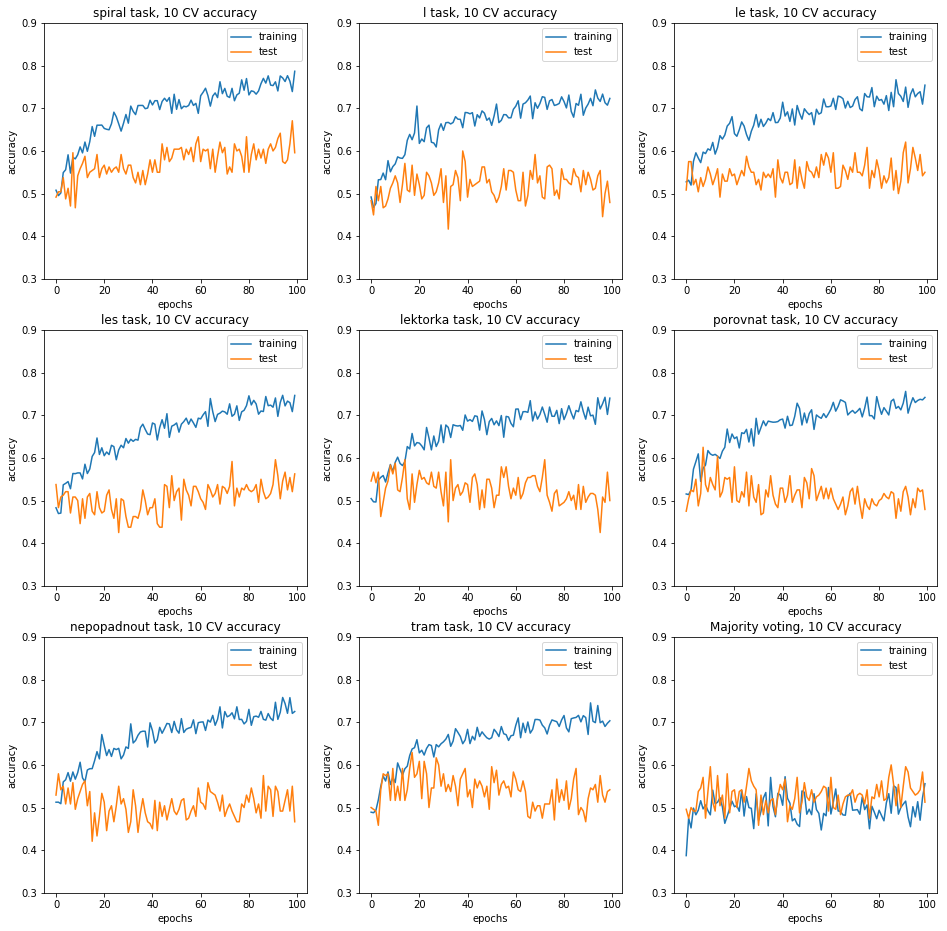

In [144]:

plt.figure(figsize=(14,14))
#for task_name,task_i in task2index.items():
for task_i,model_name in enumerate(model_names):
    task_name=model_name.split(",")[1]
    plt.subplot(2,2,task_i+1)
    #model_name="('cnn1d', '{}', 0.001, [50], 1, False, 0.2, None, None, [1], [16071], [1])".format(task_name)
    filename=join("experiments",model_name)
    metrics=[]
    for metric_type in ["train","test"]:
        with open (filename+metric_type, 'rb') as fp:
            metrics.append(pickle.load(fp))

    fold_train_metrics, fold_test_metrics=metrics
    
    model_metrics.append(fold_test_metrics)
    print_results(fold_train_metrics, fold_test_metrics,[],best_index=65)
    avg_train=np.mean(fold_train_metrics,axis=0)
    #avg_valid=np.mean(fold_valid_metrics,axis=0)
    avg_test=np.mean(fold_test_metrics,axis=0)
    
    plot(1,avg_train,None,avg_test)
    plt.title(task_name+" task, 10 CV accuracy")
plt.subplot(2,2,task_i+2)
plot(1,np.mean(vote_train_metrics,axis=0),None,np.mean(vote_test_metrics,axis=0))

plt.title("Majority voting, 10 CV accuracy")

###  Interpretation

This allows you to visualize the weights of the model, However this is an ad-hoc example for `cnn1d`

ValueError: num must be 1 <= num <= 6, not 7

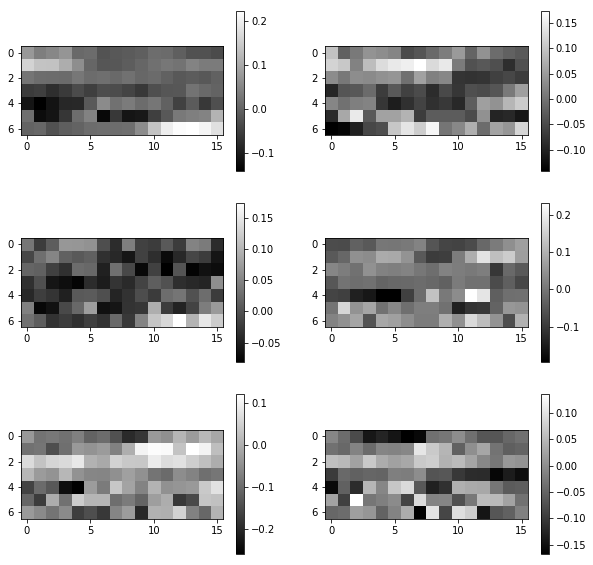

In [36]:
plt.figure(figsize=(10,10))
for j in range(on_paper.shape[0]):
    plt.subplot(3,2,j+1)
    plt.imshow(on_paper[j],cmap="gray")
    plt.colorbar()


Text(0, 0.5, 'average activation')

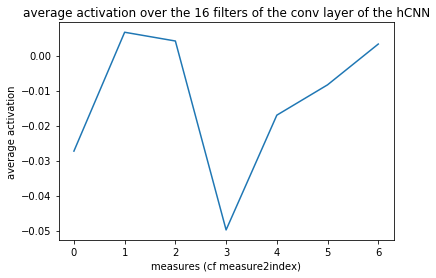

In [40]:
plt.plot(np.mean(np.mean(on_paper,axis=0),axis=1))
plt.title("average activation over the 16 filters of the conv layer of the hCNN")
plt.xlabel("measures (cf measure2index)")
plt.ylabel("average activation")

Text(0, 0.5, 'average activation')

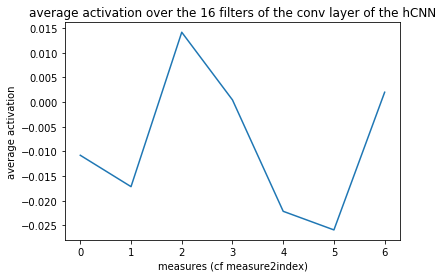

In [41]:
plt.plot(np.mean(np.mean(in_air,axis=0),axis=1))
plt.title("average activation over the 16 filters of the conv layer of the hCNN")
plt.xlabel("measures (cf measure2index)")
plt.ylabel("average activation")

In [109]:
subject=[torch.Tensor(seq.copy()).unsqueeze(0).transpose(1,2).to(device) for seq in data[8]]

model(subject)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [107]:
model=HierarchicalStrokeCRNN(input_size,conv_seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size)

In [111]:
model=model.to(device)

In [38]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)

for fold,(train_index,test_index) in enumerate(cv_generator): 
    print(fold,test_index,[targets[i] for i in test_index])

0 [ 3 25 41 43 58 63 65 69] [1, 0, 1, 1, 1, 0, 0, 0]
1 [17 19 21 30 48 50 52 56] [1, 1, 1, 1, 0, 0, 0, 0]
2 [36 37 42 57 61 62 64 68] [1, 1, 1, 1, 0, 0, 0, 0]
3 [ 2  4 24 26 31 35 59 60] [1, 1, 0, 0, 1, 1, 0, 0]
4 [10 14 29 38 45 53 55 67] [1, 1, 1, 0, 0, 0, 1, 0]
5 [ 6 18 20 28 49 51 54 66] [1, 1, 1, 0, 0, 0, 1, 0]
6 [ 7 13 32 44 70 71] [1, 1, 0, 0, 0, 1]
7 [ 0  1 16 22 23 47] [1, 1, 1, 0, 0, 0]
8 [ 5 11 15 27 39 46] [1, 1, 1, 0, 0, 0]
9 [ 8  9 12 33 34 40] [1, 1, 1, 0, 0, 0]


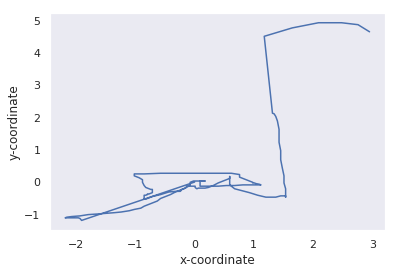

In [77]:
plot_task(data[8][5])

In [112]:
save_feats=[]
save_convs=[]
for seq in subject:
    if seq[0,measure2index["button_status"],0]==on_paper_value:
        
        c1=model.conv1(seq)
    else:
        c1=model.conv1_air(seq)
    r1=model.relu1(c1)
    save_convs.append(r1)
    p1=model.pool1(r1)   
    save_feats.append(p1)
    """drop1=model.drop1(p1)        
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    p2=model.pool2(r2)
    #flatten
    flat=p2.view(p2.size(0), -1)
    save_flat.append(flat)"""
#cat=torch.cat(save_flat,dim=1)
cat=torch.cat(save_feats,dim=2)

In [113]:
cat.shape

torch.Size([1, 16, 9])

In [114]:
cat.transpose(1,2).shape

torch.Size([1, 9, 16])

In [120]:
rnn_out,last_hidden=model.rnn(cat.transpose(1,2))

In [122]:
last_hidden[0].shape

torch.Size([1, 1, 32])

In [119]:
rnn_out[:,-1].shape

torch.Size([1, 32])

In [33]:
save_feats=[]
save_convs=[]
for seq in subject:
    if seq[0,measure2index["button_status"],0]==on_paper_value:
        
        c1=model.conv1(seq)
    else:
        c1=model.conv1_air(seq)
    r1=model.relu1(c1)
    save_convs.append(r1)
    p1=model.pool1(r1)   
    save_feats.append(p1)
    """drop1=model.drop1(p1)        
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    p2=model.pool2(r2)
    #flatten
    flat=p2.view(p2.size(0), -1)
    save_flat.append(flat)"""
#cat=torch.cat(save_flat,dim=1)
cat=torch.cat(save_feats,dim=2)
drop1=model.drop1(cat)        
c2=model.conv2(drop1)
r2=model.relu2(c2)
p2=model.pool2(r2)

'plt.figure(figsize=(16,12))\nfor j in [4]:\n    plt.subplot(3,3,j+1)\n    plt.title("filter {}".format(j))\n    plt.plot(r1.squeeze().cpu().detach().numpy()[j,:trim_to])'

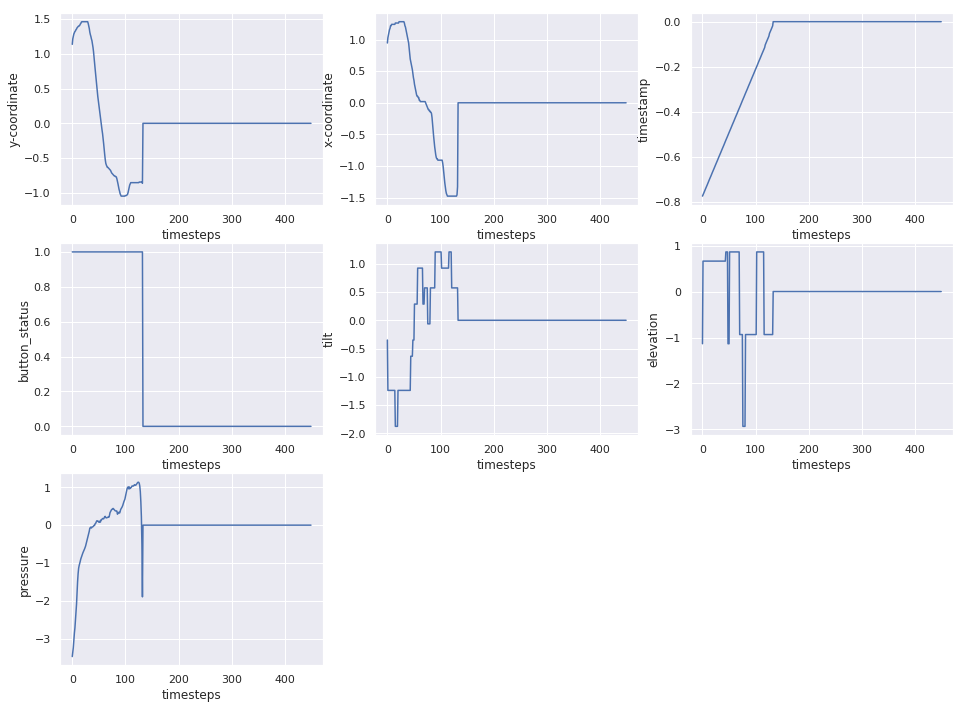

In [34]:
trim_to=450
plot_measures(data[8][0][:trim_to])
"""plt.figure(figsize=(16,12))
for j in [4]:
    plt.subplot(3,3,j+1)
    plt.title("filter {}".format(j))
    plt.plot(r1.squeeze().cpu().detach().numpy()[j,:trim_to])"""

Text(0.5, 0, 'timesteps')

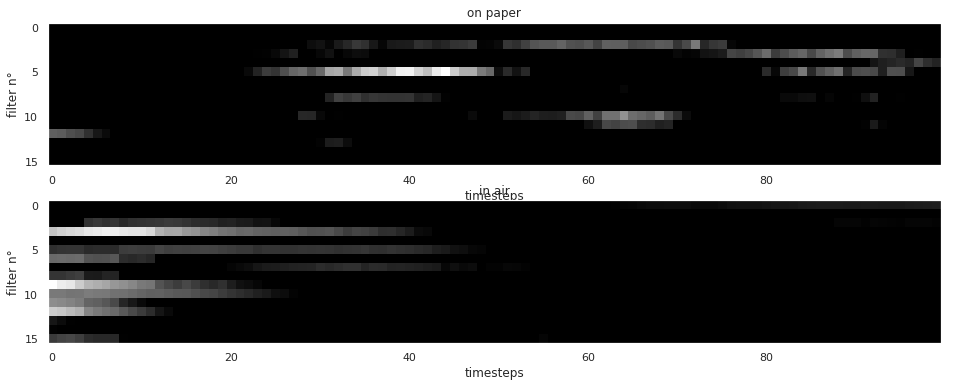

In [66]:
plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
plt.title("on paper")
plt.imshow(save_convs[0].squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")
plt.subplot(2,1,2)
plt.title("in air")
plt.imshow(save_convs[1].squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

IndexError: index 20 is out of bounds for axis 0 with size 16

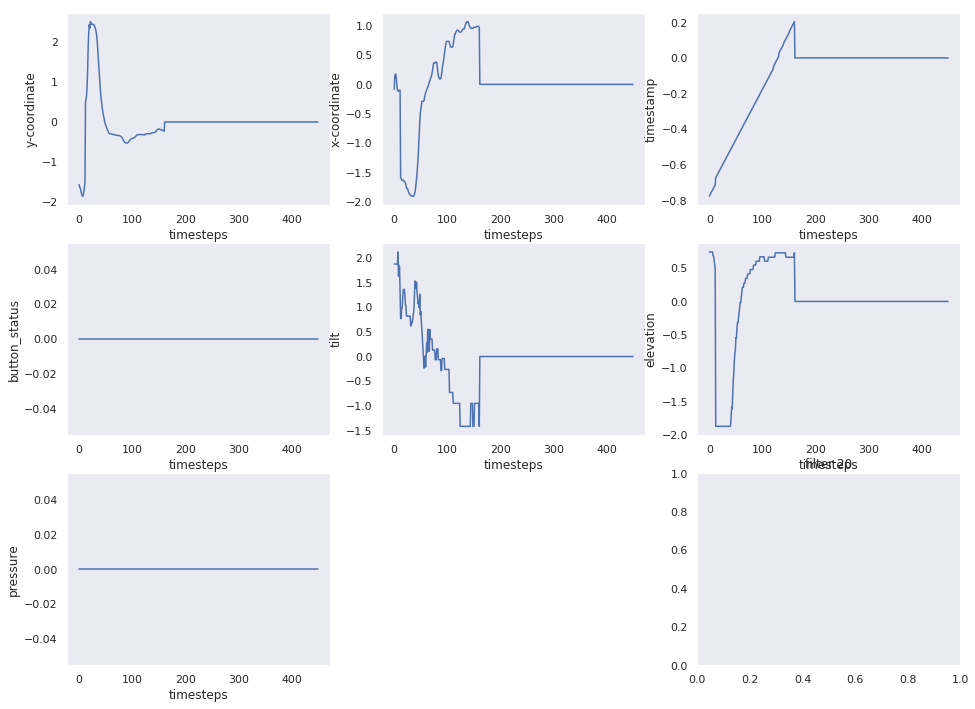

In [70]:
trim_to=450
plot_measures(data[8][1][:trim_to])
#plt.figure(figsize=(16,12))
for j in [20]:
    plt.subplot(3,3,9)
    plt.title("filter {}".format(j))
    plt.plot(r1.squeeze().cpu().detach().numpy()[j,:trim_to])

In [67]:
trim_to=None

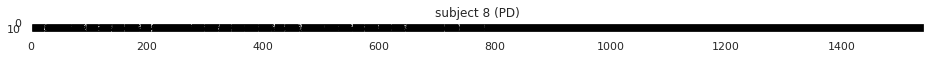

In [68]:
plt.figure(figsize=(16,10))
plt.title("subject 8 (PD)")
plt.imshow(cat.squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")

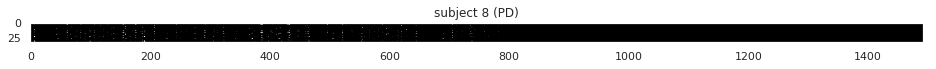

In [69]:
plt.figure(figsize=(16,6))
plt.title("subject 8 (PD)")
plt.imshow(r2.squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")

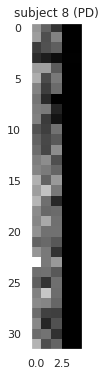

In [65]:
plt.figure(figsize=(16,6))
plt.title("subject 8 (PD)")
plt.imshow(p2.squeeze(0).cpu().detach().numpy()[:,:],cmap="gray")

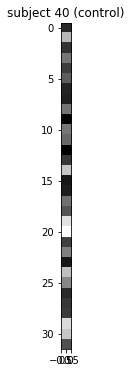

In [85]:
plt.figure(figsize=(16,6))
plt.title("subject 40 (control)")
plt.imshow(p2.squeeze(0).cpu().detach().numpy()[:,:],cmap="gray")

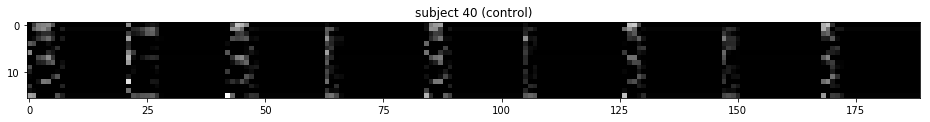

In [84]:
plt.figure(figsize=(16,6))
plt.title("subject 40 (control)")
plt.imshow(cat.squeeze().cpu().detach().numpy()[:,:],cmap="gray")

Text(0.5, 0, 'timesteps')

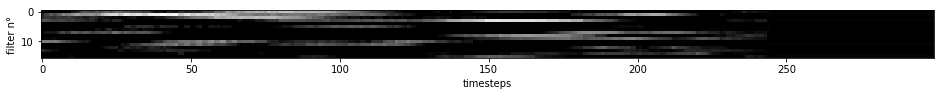

In [125]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(r1.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

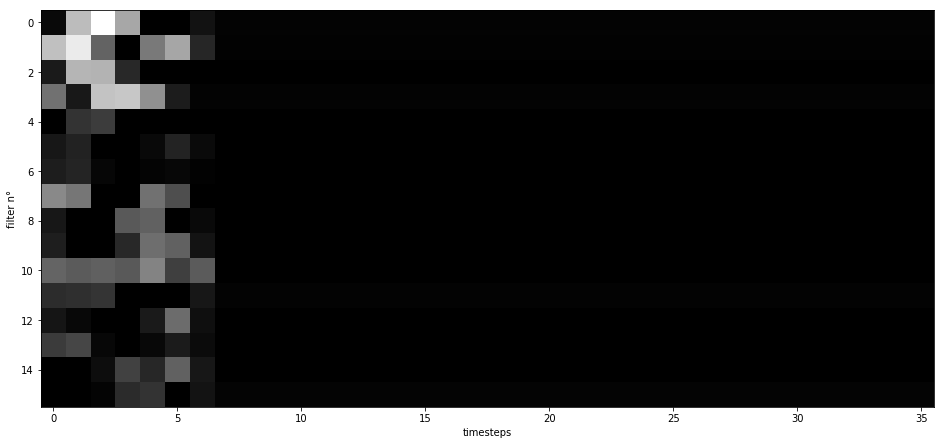

In [90]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(p1.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

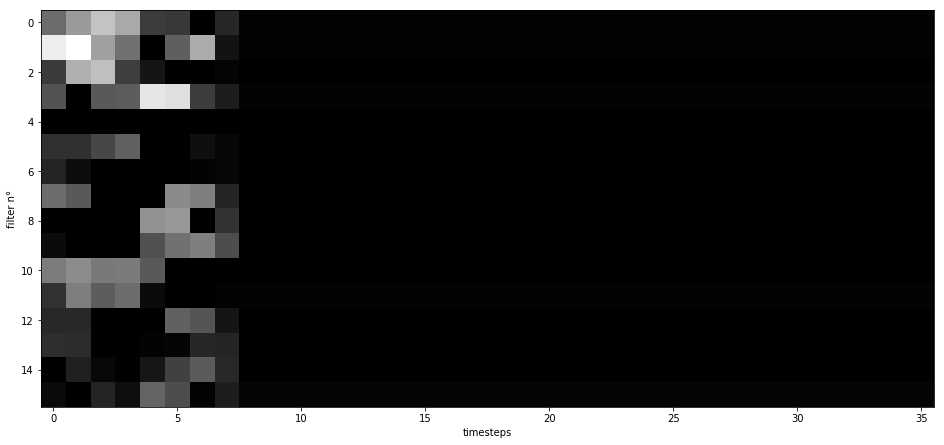

In [126]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(p1.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

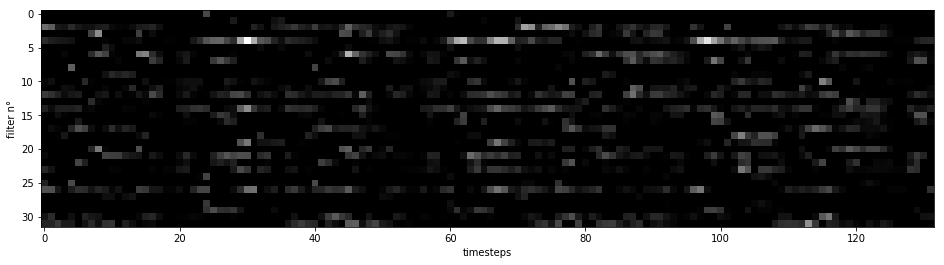

In [91]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(r2.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

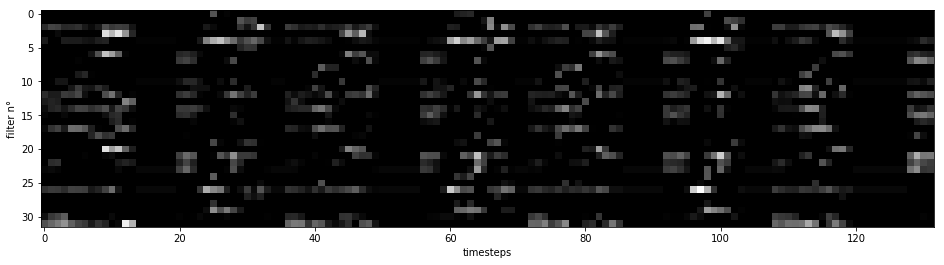

In [127]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(r2.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0, 0.5, 'activation')

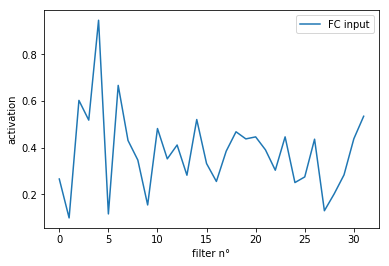

In [114]:


#plt.title("subject n°8 (PD, wrongly classified)")
plt.plot(p2.squeeze(0).cpu().detach().numpy()/5,label="FC input")
#plt.plot(model.linear1.weight.squeeze(0).cpu().detach().numpy(),label="FC weight")
plt.legend()
plt.xlabel("filter n°")
plt.ylabel("activation")

Text(0, 0.5, 'activation')

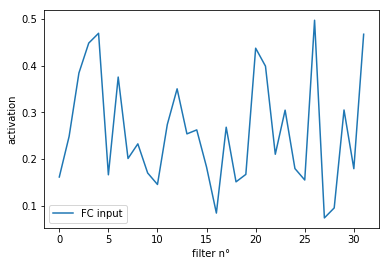

In [130]:


#plt.title("subject n°8 (PD, wrongly classified)")
plt.plot(p2.squeeze(0).cpu().detach().numpy()/5,label="FC input")
#plt.plot(model.linear1.weight.squeeze(0).cpu().detach().numpy(),label="FC weight")
plt.legend()
plt.xlabel("filter n°")
plt.ylabel("activation")